## Constructing an energy matrix using Linear regression and MCMC 

The code in this tutorial is released under the [MIT License](https://opensource.org/licenses/MIT). All the content in this notebook is under a [CC-by 4.0 License](https://creativecommons.org/licenses/by/4.0/). 

Created by Bill Ireland, Suzy Beeler and Manu Flores. 

In [10]:
#Import basic stuff
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model

#import the custom analysis software
import scipy as sp
import sys
sys.path.append('../RegSeq/')
import plot_informationfootprint as pli
import seaborn as sns

# Activate a setting that causes all plots to be inside the notebook rather than in pop-ups.
%matplotlib inline
# Get svg graphics from the notebook
%config InlineBackend.figure_format = 'svg' 

We will first load in a data set in a format accepted by the analysis software.

During this experiment, we measure the frequencies of mutant promoters in the libraries via sequencing, which we label as 'ct_0'. We also measure the number mRNA counts produced by each mutant promoter via sequencing, which we label 'ct_1'. 

We then format the resulting dataset into a format usable by the data analysis software. The dataset must have the columns 'ct', 'ct_0', 'ct_1', and 'seq' where 'ct' is the total number of reads, and 'seq' is the sequence of the mutant promoter. 

In [2]:
#We will declare the path where all the data for this notebook is stored. It can be downloaded from the
#website under 'datasets' or from the github repo (in the datasets folder).
path = '../data/'

In [3]:
#we will look at the aphA gene in a low oxygen growth condition.
genelabel = 'aphA'
#We handle most data using the Pandas package, we will load in the target data set now.
df = pd.io.parsers.read_csv(path + genelabel + 'Anaerodataset_alldone_with_large',delim_whitespace=True)
#this is what the first few lines of a typical data set looks like. From the few sequences displayed below
#Sequence 2 has the highest expression level as 9 mRNA counts were measured while only 1 library
#count was found indicating its average expression is likely to be high.
df.head()

,ct,ct_0,ct_1,seq
0,10.0,5.0,5.0,AAACAAAAAAACACATGAACGTATCTACTTGGTTCAATATAAGGAT...
1,2.0,2.0,0.0,AAACAAAAAAACACATGAACGTATCTACTTGGTTCAATATAAGGAT...
2,10.0,1.0,9.0,AAACAAAAAAAGACAGGAACGTAATGACTGGGTGAAATATAATCAT...
3,9.0,9.0,0.0,AAACAAAAAAAGACAGGAACGTAATTACTGGGTTAAATATTATCAT...
4,1.0,1.0,0.0,AAACAAAAAAAGACAGGAACGTAATTACTGGGTTAAATATTATCAT...


Next we will define necessary functions and determine the wild type sequence of the gene.

In [4]:
#we have a file with all wild type sequences for our genes. We load it in now
genedf = pd.io.parsers.read_csv(path +'wtsequences.csv')

#we extract the wild type sequence for aphA from that file.
wt = str(genedf.loc[genedf['name'] == genelabel,'geneseq'].tolist()[0])

#we convert the wild type sequence to a list.
wtlist = np.array(list(wt))

def Compute_Least_Squares(raveledmat,batch):
    '''this is a simple linear regression function that will return the coefficients from the regression.
    In this case each coefficient represents the effect on gene expression of mutation of the corresponding base.
    We use sklearn to do this regression.'''
    clf = linear_model.LinearRegression()
    clf.fit(raveledmat,batch)
    emat = clf.coef_
    return emat

Our goal is to determine the effect of mutation at each position. To do this we first need to parameterize each sequence by whether or not each base pair is mutated. This produces an array of dimensions NxL where N is the number of sequences and L is the length of each sequence.

In [5]:
#some basic parameters of our sequences
taglength = 20 
#total promoter length
seqlength = len(df['seq'][0]) - taglength #160 bp
#we create dictionaries that relate A,C,G,T to the number 1,2,3,4
seq_dict,inv_dict = pli.choose_dict('dna')

'''we initialize our array where we parameterize the sequence. There is one entry per base pair which
is equal to 1 for mutated, or 0 for wild type.'''
all_mutarr = np.zeros((len(df.index),seqlength))

#We will now parameterize our sequences
for i,row in df.iterrows():
    s = np.array(list(row['seq']))
    #clip off any sequence past the 160 bp mutated sequence length.
    s_clipped = s[:seqlength]
    #determine which bases are mutated
    all_mutarr[i,:seqlength] = (wtlist != s_clipped)

#We will use the ratio of mRNA counts to DNA counts to regress against. We add a pseudocount of 1.
thetarget = np.array((df['ct_0']+1)/(df['ct_1']+1))
#We will center the mean to be 0.
thetarget = thetarget - np.mean(thetarget)

We then need to fit the effect of mutation from the data. For illustration purposes we now show how this can be done using linear regression.

In [6]:
emat = Compute_Least_Squares(all_mutarr,thetarget)

We can now plot the results. We will see the effect of mutation on expression.

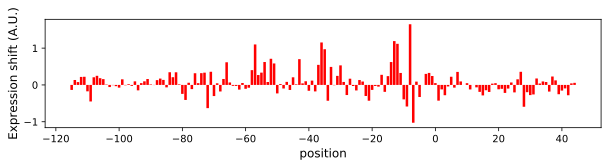

In [7]:
fig,ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Expression shift (A.U.)',fontname='DejaVu Sans',fontsize=12)
ax.set_xlabel('position',fontname='DejaVu Sans',fontsize=12)
plt.bar(range(-115,-115+seqlength),emat,color='r')
plt.show()

We will now convert the expression shift into an information footprint.

In [8]:
'''The conversion script returns the information footprint smoothed with a window size = 3
(the values are averaged with their neighbors), and also a variable called shiftcolors. Shiftcolors is
a colorcoding scheme for showing whether mutation tends to increase gene expression (repressor like) or
decrease gene expression (activator like).'''
smoothinfo, shiftcolors = pli.main(emat)

../RegSeq\plot_informationfootprint.py:131: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  background_df = pd.DataFrame(pd.np.tile(background_array,


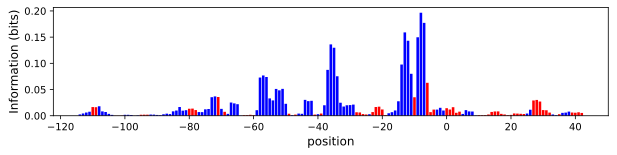

In [9]:
fig,ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)',fontname='DejaVu Sans',fontsize=12)
ax.set_xlabel('position',fontname='DejaVu Sans',fontsize=12)
ax.bar(range(-114,43),np.abs(smoothinfo),color=shiftcolors)
plt.show()


Determining the effect of mutation with a linear regression based method works well in many cases, and it has the advantage of having little computational cost. However, MCMC inference is a far more robust method, and so the MCMC method was used to generate all information footprints displayed in the paper. The MCMC inference can be run from the command line using the MPATHIC software, create by Justin Kinney. We ran all inference on the amazon cloud. The command is


`mpathic learn_model -i data_file_name -o model_file_out_name -db database_file_out_name --iterations 300000 --thin 30 --initialize rand`

Where:

`-i` designates the input datafile name 

`-o` designates the output file name

`-db` is the file name for saving all MCMC samples during the run

`--iterations` is the number of MCMC iterations to run

`--initialize` is how to initialize the inference, doing it randomly allows you to check that nomatter where you start you will converge to the same answer.

It is important to check that if you run multiple MCMC chains, you will converge to the same answer, even though you start in different places.

In the above example for aphA, we can qualitatively examine the information footprint to determine possible binding site locations. We can see that the regions in -80 to -65, -60 to -50, -40 to -30, and -18 to -5 appear to be qualitatively important for binding. We can also use an automatic technique to identify these possible binding sites (this is explained in the automatic binding site tutorial), and we can identify the RNAP binding site by studying the binding preference of the sites (this is explained in the sequence logo tutorial).  